In [1]:
import pandas as pd
import numpy as np
from collections import Counter
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import GaussianNB
import matplotlib.pyplot as plt
from sklearn.utils.validation import check_is_fitted, check_X_y
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, euclidean_distances, confusion_matrix, roc_auc_score, precision_score, recall_score, RocCurveDisplay, ConfusionMatrixDisplay

In [2]:
not_clean = pd.read_csv("/content/cardio_train.csv") 
heart_disease_data = not_clean.iloc[:,0].apply(lambda x: pd.Series(str(x).split(";")))
heart_disease_data.columns = ["id","age","gender","height","weight","ap_hi","ap_lo","cholesterol","gluc","smoke","alco","active",'cardio']

In [3]:
heart_disease_data.shape

(69301, 13)

In [4]:
heart_disease_data.head()

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
0,988,22469,1,155,69.0,130,80,2,2,0,0,1,0
1,989,14648,1,163,71.0,110,70,1,1,0,0,1,1
2,990,21901,1,165,70.0,120,80,1,1,0,0,1,0
3,991,14549,2,165,85.0,120,80,1,1,1,1,1,0
4,992,23393,1,155,62.0,120,80,1,1,0,0,1,0


In [5]:
heart_disease_data.isna().sum()

id             0
age            0
gender         0
height         0
weight         0
ap_hi          0
ap_lo          0
cholesterol    0
gluc           0
smoke          0
alco           0
active         0
cardio         0
dtype: int64

In [6]:
column_names = ["id","age","gender","height","weight",
                "ap_hi","ap_lo","cholesterol","gluc",
                "smoke","alco","active",'cardio']
for col in column_names:
    heart_disease_data[col] = pd.to_numeric(heart_disease_data[col])

In [7]:
heart_disease_data["age"] = [elem/365 for elem in heart_disease_data["age"]]

In [8]:
heart_disease_data.head(10)

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
0,988,61.558904,1,155,69.0,130,80,2,2,0,0,1,0
1,989,40.131507,1,163,71.0,110,70,1,1,0,0,1,1
2,990,60.002740,1,165,70.0,120,80,1,1,0,0,1,0
3,991,39.860274,2,165,85.0,120,80,1,1,1,1,1,0
4,992,64.090411,1,155,62.0,120,80,1,1,0,0,1,0
5,995,57.926027,1,164,61.0,100,70,1,1,0,0,1,0
6,996,49.547945,1,162,72.0,100,70,1,1,0,0,1,0
7,997,61.772603,1,161,93.0,140,90,2,1,0,0,1,1
8,999,58.219178,1,157,68.0,110,80,1,1,0,0,1,0
9,1000,61.495890,1,158,65.0,140,90,3,1,0,0,1,1


In [9]:
X = heart_disease_data.drop(columns = 'cardio').to_numpy()
y = heart_disease_data['cardio'].to_numpy()
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=5)

In [10]:
class KNN(BaseEstimator, ClassifierMixin):
    def __init__(self, k=5):
        self.k = k

    def fit(self, X, y):  
        self.X = X
        self.y = y
        return self

    def predict(self, X):
        check_is_fitted(self, ['X', 'y'])
        predictions = np.ndarray((X.shape[0],))
        for (num, elem) in enumerate(X):
            distances = euclidean_distances([elem], self.X)[0]
            neighbors = np.argpartition(distances, kth=self.k-1) 
            k_nearest_neighbors = neighbors[:self.k] 
            labels, counts = np.unique(self.y[k_nearest_neighbors], return_counts=True)
            predictions[num] = labels[counts.argmax()] 
        return predictions

In [11]:
def info(model, data, labels):
    pred = model.predict(data)
    print('Accuracy:', accuracy_score(labels, pred))
    print('Precision:', precision_score(labels, pred))
    print('Recall:', recall_score(labels, pred))
    print('ROC AUC:', roc_auc_score(labels, pred))

    figure = plt.figure(figsize=(12, 4))
    matrix = confusion_matrix(labels, pred)
    ax = plt.subplot(1, 2, 1)
    ConfusionMatrixDisplay(matrix).plot(ax=ax)
    ax = plt.subplot(1, 2, 2)
    RocCurveDisplay.from_predictions(labels, pred, ax=ax)
    plt.subplots_adjust(wspace=0.3)
    plt.show()


In [12]:
knn = GridSearchCV(Pipeline([('scaler', StandardScaler()),('KNN', KNN())]),
    {'KNN__k' : [1, 5, 9, 13]})
knn.fit(X_train, y_train)
knn_best = knn.best_estimator_
knn_best

Pipeline(steps=[('scaler', StandardScaler()), ('KNN', KNN(k=13))])

Accuracy: 0.642161460212106
Precision: 0.645709040844424
Recall: 0.6148579752367079
ROC AUC: 0.6419058315291601


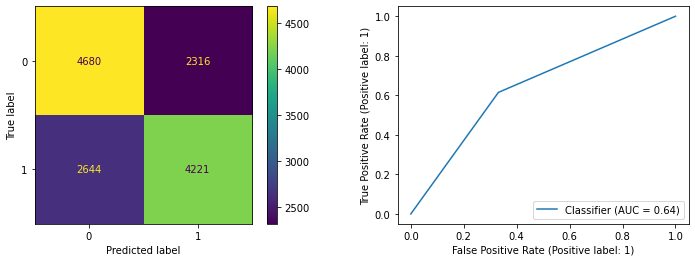

In [13]:
info(knn_best, X_test, y_test)

In [14]:
from sklearn.neighbors import KNeighborsClassifier
skl_knn = GridSearchCV(Pipeline([('scaler', StandardScaler()), ('knn', KNeighborsClassifier())]),
                    {'knn__n_neighbors': [1, 5, 9, 13]})
skl_knn.fit(X_train, y_train)
skl_knn_best = skl_knn.best_estimator_
skl_knn_best

Pipeline(steps=[('scaler', StandardScaler()),
                ('knn', KNeighborsClassifier(n_neighbors=13))])

Accuracy: 0.642161460212106
Precision: 0.645709040844424
Recall: 0.6148579752367079
ROC AUC: 0.6419058315291601


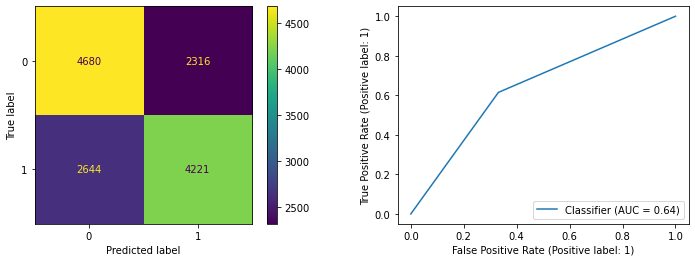

In [15]:
info(skl_knn_best, X_test, y_test)

In [16]:
import pickle
file = open('models/knn.pkl', 'wb')
pickle.dump(knn_best, file, pickle.HIGHEST_PROTOCOL)
file.close()

In [17]:
from scipy.stats import gaussian_kde
class NaiveBayes(BaseEstimator, ClassifierMixin):
    def __init__(self):
        pass
    
    def fit(self, data, labels):
        self.data = data
        self.labels = labels
        self.kde = []
        for c, count in zip(*np.unique(labels, return_counts=True)):
            self.kde.append([])
            for i in range(data.shape[1]):
                self.kde[-1].append(gaussian_kde(data[labels == c, i]))
        self.classes = np.unique(labels, return_counts=True)[1] / len(labels)
        return self
    
    def predict(self, data):
        res = np.ndarray((data.shape[0],))
        for i, obj in enumerate(data):
            prob = np.array(self.classes)
            for j in range(len(self.classes)):
                for k, kde in enumerate(self.kde[j]):
                    prob[j] *= kde(obj[k])[0]
            res[i] = prob.argmax()
        return res

Accuracy: 0.6319890339802323
Precision: 0.8276374442793462
Recall: 0.32454479242534595
ROC AUC: 0.6291105894659605


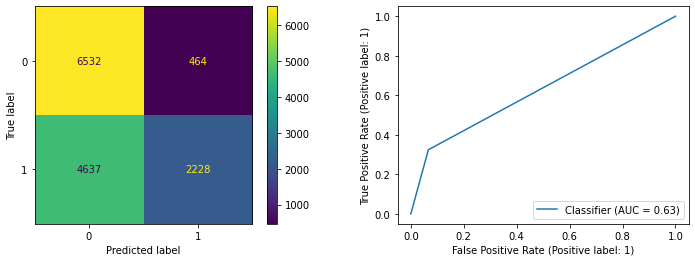

In [18]:
nb = Pipeline([('NBayes', NaiveBayes())])
nb.fit(X_train, y_train)
info(nb, X_test, y_test)

Accuracy: 0.5557319096746266
Precision: 0.7680060652009097
Recall: 0.14756008739985432
ROC AUC: 0.5519104039057591


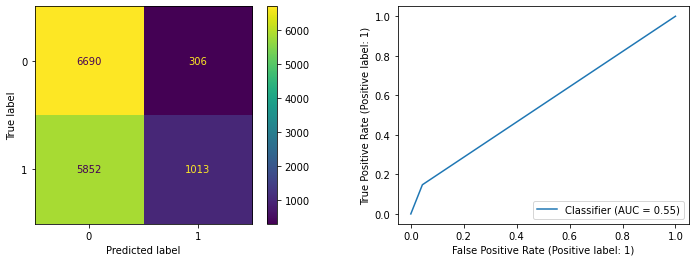

In [19]:
skl_nb = Pipeline([("SKL_NB", GaussianNB())])
skl_nb.fit(X_train, y_train)
info(skl_nb, X_test, y_test)

In [20]:
file = open('models/nb.pkl', 'wb')
pickle.dump(nb, file, pickle.HIGHEST_PROTOCOL)
file.close()

In [21]:
class SVM(BaseEstimator, ClassifierMixin):
    def __init__(self, epochs=1, batch_size=15, lr=0.01, alpha=0.001):
        self.epochs = epochs
        self.batch_size = batch_size
        self.lr = lr
        self.alpha = alpha
    
    def fit(self, X, y):
        self.W = np.random.normal(0, 1, (X.shape[1]+1,))
        y = y * 2 - 1
        X = np.concatenate((X, np.ones((X.shape[0],1))), axis=1)
        for epoch in range(self.epochs):
            for i in range(self.batch_size, len(X), self.batch_size):
                X_batch = X[i:i+self.batch_size]
                y_batch = y[i:i+self.batch_size]
                gradient = 2 * self.alpha * self.W
                for i, x in enumerate(X_batch):
                    if 1 - x.dot(self.W) * y_batch[i] > 0:
                        gradient -= x * y_batch[i]
                self.W -= self.lr * gradient
        return self

    def predict(self, data):
        return (np.sign(np.concatenate((data, np.ones((data.shape[0],1))), axis=1).dot(self.W)) + 1) / 2

In [33]:
svm = GridSearchCV(Pipeline([("SVM", SVM())]),
    {'SVM__epochs' : [1, 5, 10],
    'SVM__batch_size' : [5, 10, 15],
    'SVM__lr' : [0.01, 0.05, 0.25],
    'SVM__alpha' : [0.1, 0.01, 0.001]})

In [34]:
svm.fit(X_train, y_train)
svm_best = svm.best_estimator_
svm_best

Pipeline(steps=[('SVM', SVM(batch_size=10, epochs=10))])

Accuracy: 0.5086934564605728
Precision: 0.5564681724845996
Recall: 0.03947560087399855
ROC AUC: 0.5043004076411159


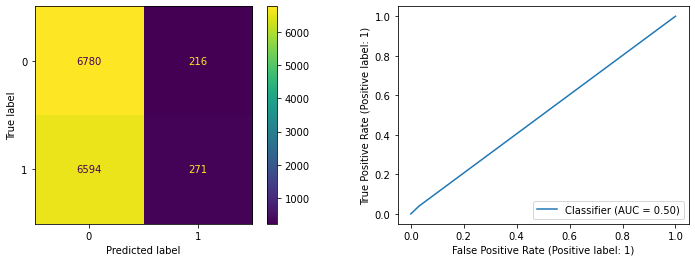

In [35]:
info(svm_best, X_test, y_test)

In [ ]:
from sklearn.svm import SVC
skl_svm = GridSearchCV(Pipeline([('SKL_SVC', SVC())]),
    {'SKL_SVC__kernel' : ['linear', 'poly']})
skl_svm.fit(X_train, y_train)
skl_svm_best = skl_svm.best_estimator_
skl_svm_best

In [ ]:
info(skl_svm_best, X_test, y_test)

In [ ]:
file = open('models/svm.pkl', 'wb')
pickle.dump(svm_best, file, pickle.HIGHEST_PROTOCOL)
file.close()

In [26]:
class LogisticRegression(BaseEstimator, ClassifierMixin):
    def __init__(self, lr=0.1, batch=10, epochs=1, alpha=0.0001):
        self.lr = lr
        self.batch = batch
        self.epochs = epochs
        self.alpha = alpha
    
    def fit(self, data, labels):
        self.w = np.random.normal(0, 1, (data.shape[1]+1,))
        data = np.concatenate((data, np.ones((data.shape[0],1))), axis=1)
        for _ in range(self.epochs):
            for i in range(self.batch, len(data), self.batch):
                data_batch = data[i-self.batch:i]
                labels_batch = labels[i-self.batch:i]
                
                pred = self.sigmoid(np.dot(self.w, data_batch.T))
                grad = 2 * self.alpha * self.w + np.dot(pred - labels_batch, data_batch)
                
                self.w -= self.lr * grad
        return self
    
    def sigmoid(self, x):
        return 1 / (1 + np.exp(-x))
    
    def predict(self, data):
        return (self.sigmoid(np.concatenate((data, np.ones((data.shape[0],1))), axis=1).dot(self.w)) > 0.5).astype('int64')

In [29]:
from sklearn.preprocessing import Normalizer
lr = GridSearchCV(Pipeline([('normalizer', Normalizer()), ('LR', LogisticRegression())]),
                    {'LR_learning_rate': [0.1, 0.01, 0.001], 'LR_epochs': [1, 5, 10], 
                     'LR_batch': [10, 20, 30], 'LR_alpha': [0.0001, 0.001, 0.01]})
lr.fit(X_train, y_train)
lr_best = lr.best_estimator_

ValueError: ignored

In [ ]:
info(lr_best, X_test, y_test)

In [ ]:
skl_lr = GridSearchCV(Pipeline([('normalizer', Normalizer()), ('S_LR', LogisticRegression())]),
                    {'S_LR_learning_rate': [0.1, 0.01, 0.001], 'S_LR_epochs': [1, 5, 10], 
                     'S_LR_batch': [10, 20, 30], 'S_LR_alpha': [0.1, 0.01, 0.001]})
skl_lr.fit(X_train, y_train)
skl_lr_best = skl_lr.best_estimator_
skl_lr_best

In [ ]:
info(skl_lr_best, X_test, y_test)

In [ ]:
file = open('models/lr.pkl', 'wb')
pickle.dump(lr_best, file, pickle.HIGHEST_PROTOCOL)
file.close()